##### This notebook contains code for getting statistic indices after ML and plotting them 
##### Fluid cognition


### Load libraries

In [2]:
## IMPORTANT !

# In the first order need to set the number of CPU 
# for calculation before launching (depends on computer's number of cores)
n_jobs= 30

#libraries
import pandas as pd
import numpy as np
import os
import sys
import shutil
import glob
import joblib
import warnings
from datetime import date, datetime

from sklearn.decomposition import PCA
from sklearn.impute import SimpleImputer
from sklearn.linear_model import ElasticNet
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import GroupKFold
from sklearn.model_selection import LeavePGroupsOut
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.utils import resample

import matplotlib.pyplot as plt
import seaborn as sns

from scipy.stats import pearsonr
import scipy.stats as st

from nilearn import image as nli
from nilearn import plotting

In [3]:
#load path to orig tables
path='/media/data/HCPAging/data/MLTablesMultCon/'

In [4]:
#load some features tables as dictionary
features = {
    'carit1':pd.read_csv(path+'carit-con1.csv', index_col=0),
    'surf':pd.read_csv(path+'surf.csv', index_col=0),
    'subc':pd.read_csv(path+'subc.csv', index_col=0),
    'VolBrain':pd.read_csv(path+'VolBrain.csv', index_col=0),
    
    'rest':pd.read_csv(path+'rest_hpass.csv', index_col=0) 

}


In [5]:
#load labels from orig tables
ind_task = features['carit1'].columns.values
ind_anat = features['surf'].columns.values
ind_subc = features['subc'].columns.values
ind_bVol = features['VolBrain'].columns.values
ind_FC = features['rest'].columns.values

### CV stats

In [6]:
#path to ML outputs
nmf='/media/data/HCPAging/data/MLTablesMultCon/output_5cv_sexAdj_noStdTarg_STDstackFeatures/output_5cv_sexAdj_noStdTarg_STDstackFeatures_nih_fluidcogcomp_unadjusted'
path2 = nmf+'/'

#read number of folds
folders = sorted((os.listdir(path2)))[:5]
print(path2)
print(folders)

/media/data/HCPAging/data/MLTablesMultCon/output_5cv_sexAdj_noStdTarg_STDstackFeatures/output_5cv_sexAdj_noStdTarg_STDstackFeatures_nih_fluidcogcomp_unadjusted/
['Fold_0', 'Fold_1', 'Fold_2', 'Fold_3', 'Fold_4']


In [7]:
#Labels
#labels for single modalities and stack
lblY = ['CARIT: NoGo-Go',
'CARIT: Go',
'CARIT: NoGo',
'FACENAME: Encoding',
'FACENAME: Recall',
'FACENAME: Distractor',
'FACENAME: Encoding-Recall',
'FACENAME: Encoding-Distractor',
'FACENAME: Recall-Distractor',
'VISMOTOR: Vismotor',
'CARIT: FC',
'FACE-NAME: FC',
'VISUAL MOTOR: FC',
'Cortical Thickness',
'Cortical Surface',
'Subcortical Volume',
'Total Brain Volume',
'Resting State FC',
'Stacked: All', #set1
'Stacked: Task Contrast', #set2
'Stacked: Non Task', #set3
'Stacked: Task FC', #set4
'Stacked: Task Contrast & FC', #set5
'Stacked: All excluding Task FC', #set6  with Task GLM
'Stacked: All excluding Task Contrast',  #set7 with Task FC
'Stacked: Resting and Task FC'] #set8

#labels for single modalities within each stack
lbl_set1 = ['carit1', 'carit3', 'carit4', 'face1', 'face2', 'face3', 'face4', 'face5', 'face6', 'vism', 
            'carit_FC', 'face_FC', 'vism_FC', 
            'cort', 'surf', 'subc', 'VolBrain', 'rest']

lbl_set2 = ['carit1', 'carit3', 'carit4', 'face1', 'face2', 'face3', 'face4', 'face5', 'face6', 'vism']
lbl_set3 = ['cort', 'subc', 'surf', 'rest', 'VolBrain']

lbl_set4 = ['carit_FC', 'face_FC', 'vism_FC']
lbl_set5 = ['carit1', 'carit3', 'carit4', 'face1', 'face2', 'face3', 'face4', 'face5', 'face6', 'vism', 
            'carit_FC', 'face_FC', 'vism_FC']
lbl_set6 = ['carit1', 'carit3', 'carit4', 'face1', 'face2', 'face3', 'face4', 'face5', 'face6', 'vism', 
            'cort', 'subc', 'surf', 'rest', 'VolBrain']
lbl_set7 = ['carit_FC', 'face_FC', 'vism_FC', 'cort', 
            'subc', 'surf', 'rest', 'VolBrain']
lbl_set8 = ['carit_FC', 'face_FC', 'vism_FC', 'rest']



In [ ]:
"""#for train subset

#assamble y_pred from all folds into one table

#open dict for storing results
dt_ypred_all = {}
#launch a loop for assembling
for fold in folders:
    #read saved tables
    df1 = pd.read_csv(path2+fold+'/2level_test1_y_pred_singleML.csv', index_col=0)
    df2 = pd.read_csv(path2+fold+'/2level_test1_y_pred_stacked.csv', index_col=0)
    yrl = pd.read_csv(path2+fold+'/target_y_train2.csv', index_col=0, squeeze=True)
    #concat all in one for one fold
    df_y_rp = pd.concat([df1,df2], axis=1)
    df_y_rp['y_real'] = yrl
    df_y_rp['fold'] = np.full(len(yrl), fold[-1], dtype=int)
    #write to dict
    dt_ypred_all[fold] = df_y_rp
    
#transform dict to one table
df_y_all = dt_ypred_all[folders[0]]
for fold in folders[1:]:
    df_y_all = pd.concat([df_y_all, dt_ypred_all[fold]], axis=0)
#save
df_y_all.to_csv(path2+'all_fold_y-pred_y-obs_train.csv')"""

In [8]:
#for test subset

#assamble y_pred from all folds into one table

#open dict for storing results
dt_ypred_all = {}
#launch a loop for assembling
for fold in folders:
    #read saved tables
    df1 = pd.read_csv(path2+fold+'/3level_test2_y_pred_singleML.csv', index_col=0)
    df2 = pd.read_csv(path2+fold+'/3level_test2_y_pred_stacked.csv', index_col=0)
    yrl = pd.read_csv(path2+fold+'/target_y_test.csv', index_col=0, squeeze=True)
    #yrl.index.name = None
    #concat all in one for one fold
    df_y_rp = pd.concat([df1,df2], axis=1)
    df_y_rp['y_real'] = yrl
    df_y_rp['fold'] = np.full(len(yrl), fold[-1], dtype=int)
    #write to dict
    dt_ypred_all[fold] = df_y_rp
    
#transform dict to one table
df_y_all = dt_ypred_all[folders[0]]
for fold in folders[1:]:
    df_y_all = pd.concat([df_y_all, dt_ypred_all[fold]], axis=0)
#save
df_y_all.to_csv(path2+'all_fold_y-pred_y-obs.csv')

In [10]:
#assamble performance indexes into separete tables and save

#open dict for storing fold's results
dt_r2 = {}
dt_mse = {}
dt_mae = {}
dt_cor = {}
#launch a loop for assembling
for fold in folders:
    #read saved tables
    df1 = pd.read_csv(path2+fold+'/3level_test2_perf_elnet.csv', index_col=0) 
    df2 = pd.read_csv(path2+fold+'/3level_test2_perf_stacked.csv', index_col=0)
    df_p = pd.concat([df1, df2], axis=1)
    #assign to dict
    dt_r2[fold] = df_p.iloc[0,:]
    dt_mse[fold] = df_p.iloc[1,:]
    dt_mae[fold] = df_p.iloc[2,:]
    dt_cor[fold] = df_p.iloc[3,:]
#transfrom dict to tables
df_r2 = pd.DataFrame(dt_r2).T
df_mse = pd.DataFrame(dt_mse).T
df_mae = pd.DataFrame(dt_mae).T
df_cor = pd.DataFrame(dt_cor).T
#and save these tables
df_r2.to_csv(path2+'r2_all_fold_cv_perf.csv')
df_mse.to_csv(path2+'mse_all_fold_cv_perf.csv')
df_mae.to_csv(path2+'mae_all_fold_cv_perf.csv')
df_cor.to_csv(path2+'cor_all_fold_cv_perf.csv')

In [11]:
#creating table of mean cv performance


df_mper = pd.DataFrame({'r2' : df_r2.mean(),
                       'mse' : df_mse.mean(),
                       'mae' : df_mae.mean(),
                       'cor' : df_cor.mean()})
#df_mper.index = lblY

#save it
df_mper.to_csv(path2+'mean_cv_perf.csv')

#display sorting by r2
print('Mean CV Performance')
display(df_mper.sort_values(by='r2', ascending=False))

Mean CV Performance


r2         mse       mae       cor
set1      0.381918   94.412056  7.706425  0.626779
set6      0.377735   95.010327  7.732404  0.624170
set7      0.363630   97.383186  7.726739  0.607610
set3      0.339916  101.010575  7.888035  0.591768
set5      0.329041  102.472113  8.007601  0.584820
set2      0.312947  104.947182  8.114948  0.573854
set8      0.311821  105.584739  8.067084  0.564672
set4      0.274371  111.176805  8.300893  0.530603
cort      0.264275  112.649802  8.402387  0.528019
face6     0.234328  117.647748  8.678100  0.494005
rest      0.232996  117.934932  8.592595  0.513779
face5     0.231936  117.992106  8.702153  0.495815
face_FC   0.225559  118.912722  8.662297  0.524999
VolBrain  0.222601  119.198602  8.573806  0.485615
subc      0.221263  119.444623  8.631166  0.486937
face3     0.182010  125.434481  8.788541  0.433147
face2     0.172899  127.054532  8.977587  0.435338
vism_FC   0.168150  127.690868  8.957850  0.442780
carit_FC  0.163348  128.292390  9.012359  0.440471
face1     0.162041  128.717552  9.042976  0.422711
vism      0.153550  129.823914  9.108882  0.418566
surf      0.095736  138.618419  9.499163  0.350671
carit3    0.077650  141.291128  9.521536  0.332868
face4     0.063477  143.473897  9.757073  0.305317
carit4    0.048927  146.312492  9.668240  0.264737
carit1    0.022626  150.462513  9.774876  0.216891

In [12]:
#creating table of std cv performance
df_stper = pd.DataFrame({'r2' : df_r2.std(),
                       'mse' : df_mse.std(),
                       'mae' : df_mae.std(),
                       'cor' : df_cor.std()})
#df_stper.index = lblY

#save it
df_stper.to_csv(path2+'mean_cv_perf_stDev.csv')

#display sorting by r2
print('StD of CV Performance')
display(df_stper.loc[(df_mper.sort_values(by='r2', ascending=False)).index, :])

StD of CV Performance


r2        mse       mae       cor
set1      0.071517   5.110425  0.408285  0.059137
set6      0.079543   6.418006  0.444431  0.065049
set7      0.065777   7.344965  0.345794  0.054328
set3      0.069048   7.820623  0.382923  0.058785
set5      0.093531   9.011352  0.537475  0.074602
set2      0.097484   9.945752  0.557916  0.076503
set8      0.025472   4.893771  0.246943  0.024572
set4      0.053846   5.631589  0.380010  0.053616
cort      0.084553  10.836252  0.560584  0.094644
face6     0.073626  13.524602  0.486928  0.069355
rest      0.027994  10.051031  0.378373  0.027068
face5     0.053909  10.931449  0.308587  0.053761
face_FC   0.029919   7.777820  0.316456  0.025895
VolBrain  0.060400   8.545288  0.448874  0.068056
subc      0.059153   9.327303  0.582015  0.073377
face3     0.082769  12.101042  0.335133  0.095757
face2     0.058814  12.276992  0.545040  0.073006
vism_FC   0.052635   9.891399  0.499877  0.078534
carit_FC  0.060588   8.414299  0.519625  0.092107
face1     0.077832  14.060100  0.574186  0.083448
vism      0.076194  11.671227  0.504101  0.075772
surf      0.047328   5.329565  0.528726  0.098920
carit3    0.085724  10.083198  0.675320  0.109569
face4     0.074887   8.123329  0.388174  0.103174
carit4    0.033644  13.858548  0.581950  0.104578
carit1    0.030860  15.356805  0.562150  0.092684

### Bootstrapping

In [13]:
#bootstrapping
i=0
#empty dict for storing indexes after each trial
dt_boot={}
while i<5000: #number of trials (shuffles)
    #shuffle
    boot = resample(df_y_all, replace=True, n_samples=len(df_y_all.index), random_state=i)
    #calculate indexes for this trial
    cor, r2, mse, mae, cols = [], [], [], [], []
    for col in boot.columns[0:-2]:
        corr, _ = pearsonr(boot['y_real'], boot[col])
        cor += [corr]
        r2 += [r2_score(boot['y_real'], boot[col])]
        mse += [mean_squared_error(boot['y_real'], boot[col])]
        mae += [mean_absolute_error(boot['y_real'], boot[col])]
        cols +=[col]
    #write it to dict
    dt_boot[i] = pd.DataFrame({'r2':r2, 'mse':mse, 'mae':mae, 'cor':cor}, index = cols)
    i+=1

#transform dict to mo convenient tables sorted by type of index
#empty dict
dbt_r2 = {}
dbt_mse = {}
dbt_mae = {}
dbt_cor = {}
#aassign each index to own dict
for key in dt_boot.keys():
    dbt_r2[key] = dt_boot[key].iloc[:,0]
    dbt_mse[key] = dt_boot[key].iloc[:,1]
    dbt_mae[key] = dt_boot[key].iloc[:,2]
    dbt_cor[key] = dt_boot[key].iloc[:,3]
#transform to tables
bt_r2 = pd.DataFrame(dbt_r2).T
bt_mse = pd.DataFrame(dbt_mse).T
bt_mae = pd.DataFrame(dbt_mae).T
bt_cor = pd.DataFrame(dbt_cor).T
#save tables
bt_r2.to_csv(path2+'r2_bootstrap.csv')
bt_mse.to_csv(path2+'mse_bootstrap.csv')
bt_mae.to_csv(path2+'mae_bootstrap.csv')
bt_cor.to_csv(path2+'cor_bootstrap.csv')

#create table with mean performance
bt_mean = pd.DataFrame({'r2': np.array(bt_r2.mean()),
                        'mse': np.array(bt_mse.mean()),
                        'mae': np.array(bt_mae.mean()),
                        'cor': np.array(bt_cor.mean()),
                             }, index = bt_r2.columns)
#bt_mean.index = lblY
#save mean table
bt_mean.to_csv(path2+'mean_boot_perf.csv')

#display
print('Mean Performance based on Bootstrapping of Predicted and Observed Values across Test Folds')
display(bt_mean.sort_values(by='r2', ascending=False))

Mean Performance based on Bootstrapping of Predicted and Observed Values across Eight Test Folds


r2         mse       mae       cor
set1      0.389580   94.395060  7.705929  0.626171
set6      0.385591   95.009190  7.732207  0.623166
set7      0.371169   97.265253  7.720807  0.610674
set3      0.347476  100.908311  7.882899  0.592679
set5      0.337615  102.439467  8.008008  0.585838
set2      0.321503  104.922803  8.115235  0.574310
set8      0.318139  105.513204  8.063953  0.565654
set4      0.282200  111.083542  8.296885  0.532915
cort      0.272826  112.464136  8.396330  0.524475
face6     0.240375  117.569784  8.676432  0.494175
rest      0.238734  117.862816  8.587765  0.511231
face5     0.238091  117.909429  8.698129  0.491504
face_FC   0.232966  118.774948  8.655694  0.523642
VolBrain  0.229978  119.113536  8.569817  0.481552
subc      0.229000  119.289402  8.627288  0.480601
face3     0.190700  125.277594  8.781274  0.439022
face2     0.180076  126.917899  8.971629  0.427321
vism_FC   0.175943  127.587287  8.951992  0.435231
carit_FC  0.172134  128.163354  9.005985  0.428850
face1     0.169049  128.614173  9.038934  0.414353
vism      0.160921  129.833466  9.106664  0.406435
surf      0.104984  138.537866  9.494789  0.327037
carit3    0.087964  141.184565  9.518095  0.300459
face4     0.073603  143.391278  9.754238  0.277759
carit4    0.055995  146.148860  9.660553  0.241240
carit1    0.029253  150.318377  9.768982  0.177096

### Plotting

### Feature coefficients order within models

#### Feature coefficients for stacked modality models

In [14]:
#extract feature importance from saved models

dct_stack_coeff={} #empty dct to store 

nsets = ['set1', 'set2', 'set3', 'set4', 'set5', 'set6', 'set7', 'set8']
lblssets = [lbl_set1, lbl_set2, lbl_set3, lbl_set4, lbl_set5, lbl_set6, lbl_set7, lbl_set8]

for nset, lblsset in zip(nsets, lblssets):
    dct_ = {}
    #extracting feature importance for each fold and each stack model
    for fold in folders:
        dct_[fold] = (joblib.load(path2+fold+'/'+nset+'_stacked_model.sav')).named_steps['elasticnet'].coef_
    df = pd.DataFrame(dct_ , index=lblsset).T 
    #save as separate table
    df.to_csv(path2+nset+'_stacked_coeffs.csv') 
    #save to dictionary
    dct_stack_coeff[nset] = df

In [15]:
#print mean feature importance for each stack before plotting

for key in dct_stack_coeff.keys():
    print(key)
    display(dct_stack_coeff[key].mean().sort_values(ascending=False))
    print(' ')

set1


surf        1.854452
vism        1.770078
face3       1.719885
carit3      1.479638
face6       1.150462
cort        1.104959
carit1      1.099417
face1       0.974024
face5       0.933597
carit4      0.659173
face_FC     0.486451
face4       0.444133
rest        0.427022
subc        0.104507
face2       0.048271
vism_FC     0.036229
carit_FC   -0.022588
VolBrain   -0.590231
dtype: float64

 
set2


vism      2.099678
face3     2.033385
carit3    1.745731
face6     1.488142
face5     1.424712
carit1    1.112026
face1     1.110521
carit4    1.101039
face4     0.512350
face2     0.192086
dtype: float64

 
set3


rest        4.866703
cort        3.613771
surf        3.371603
subc        1.197588
VolBrain   -2.008861
dtype: float64

 
set4


face_FC     4.265712
vism_FC     3.114706
carit_FC    2.352151
dtype: float64

 
set5


vism        1.922633
face3       1.852577
carit3      1.593917
face6       1.324002
face5       1.211761
carit1      1.016077
carit4      0.976003
face1       0.959522
face_FC     0.725180
carit_FC    0.487721
face4       0.456372
vism_FC     0.395920
face2       0.053361
dtype: float64

 
set6


surf        1.866632
vism        1.772307
face3       1.738098
carit3      1.507361
face6       1.221632
cort        1.132851
carit1      1.107471
face1       1.039227
face5       0.954544
carit4      0.696487
rest        0.586511
face4       0.409455
subc        0.171662
face2       0.097801
VolBrain   -0.636088
dtype: float64

 
set7


cort        3.088558
face_FC     2.838152
surf        2.762609
rest        2.193023
vism_FC     1.631690
carit_FC    0.683533
subc        0.558184
VolBrain   -1.988318
dtype: float64

 
set8


face_FC     3.330279
rest        3.105956
vism_FC     2.250094
carit_FC    1.531258
dtype: float64

##### Plotting stack modality feature importances

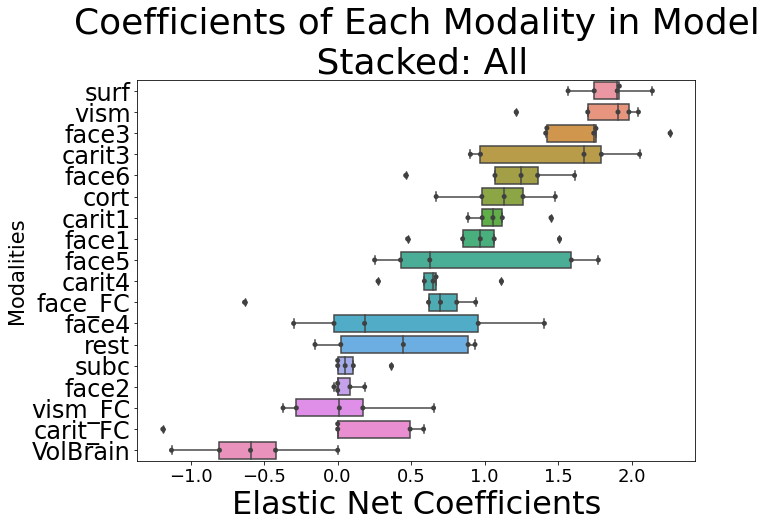

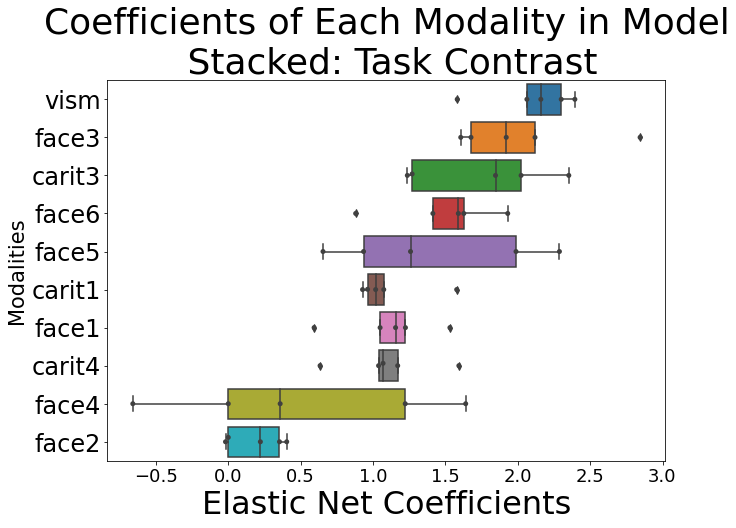

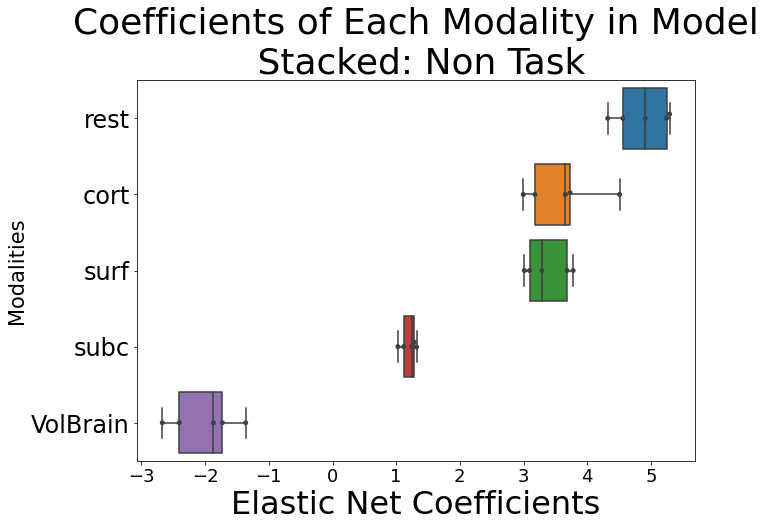

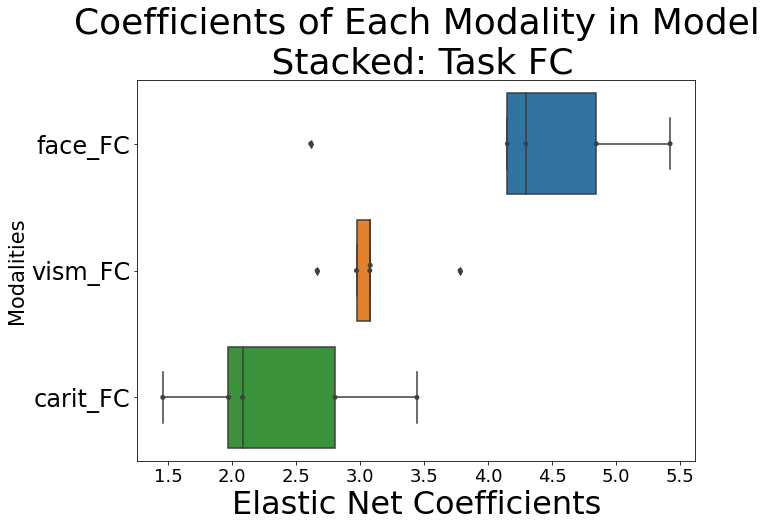

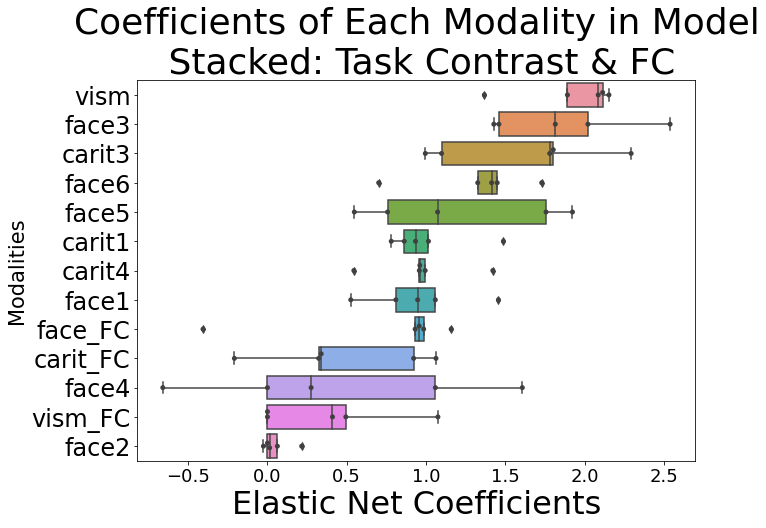

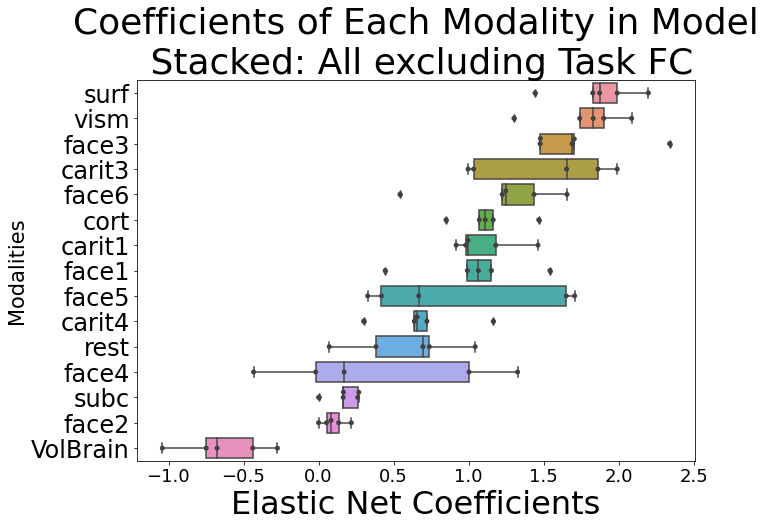

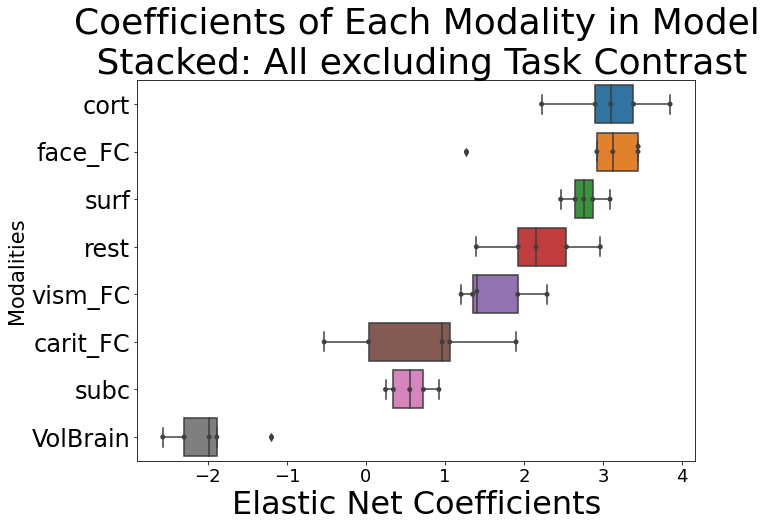

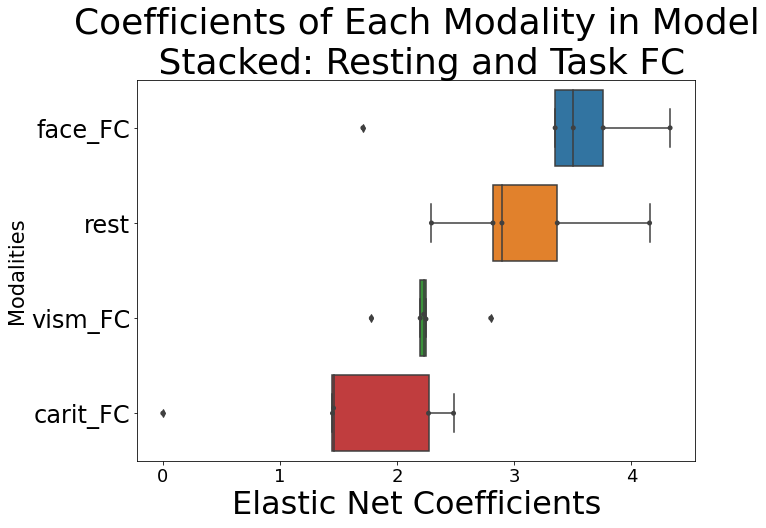

In [16]:
#plot stacked model coeffs 

for key, label in zip(dct_stack_coeff.keys(), lblY[-8:]):
    d=dct_stack_coeff[key].reindex(columns = dct_stack_coeff[key].mean().sort_values(ascending=False).index)

    plt.figure(figsize=(10,7))

    sns.boxplot(data=d, orient="h")
    sns.swarmplot(data=d, color=".25", orient="h")

    plt.xticks(fontsize=18) 
    plt.yticks(fontsize=24)
    plt.xlabel('Elastic Net Coefficients', fontsize=32)
    plt.ylabel('Modalities', fontsize=21)
    plt.title('Coefficients of Each Modality in Model\n '+label ,fontsize=36)

    plt.show()

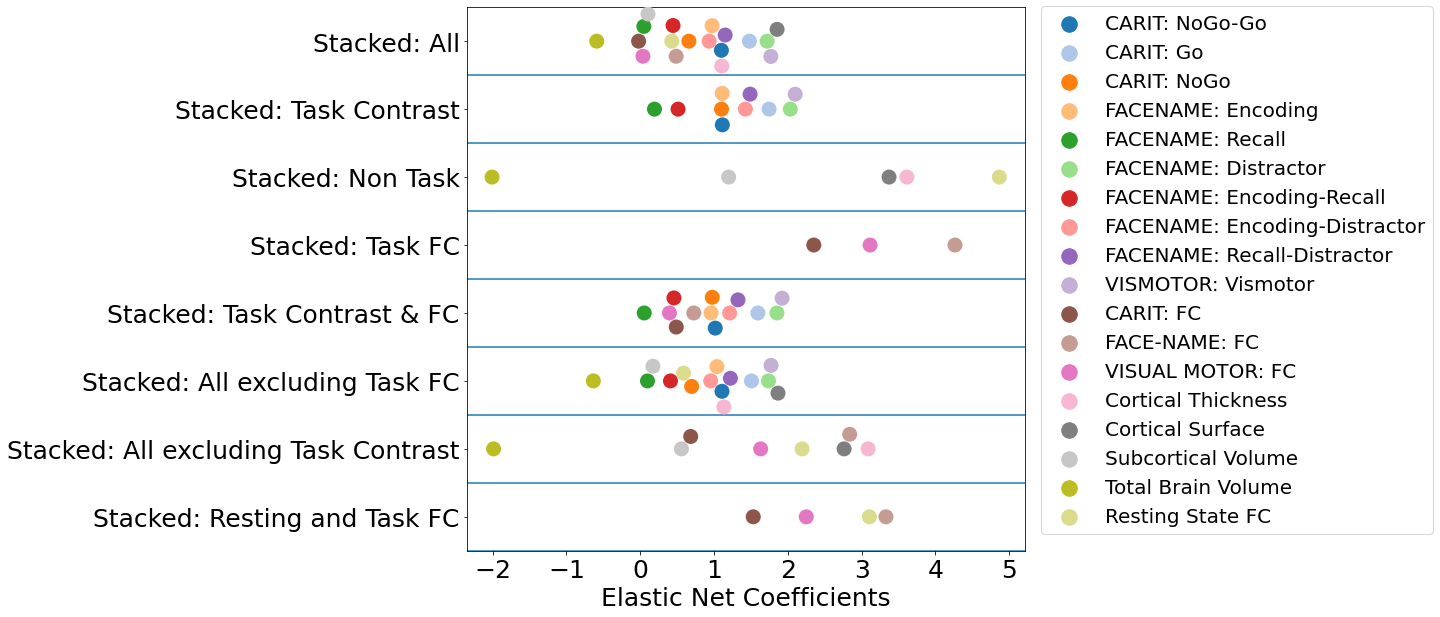

In [17]:
#Plot stacked model coefficients in different way

#non-std coefficients

#calculate mean for each stacking set
dct_mean_stack_coef = {}
for key in dct_stack_coeff.keys():
    dct_mean_stack_coef[key] = dct_stack_coeff[key].mean()
df_mean_stack_coef = pd.DataFrame(dct_mean_stack_coef)
df_mean_stack_coef = df_mean_stack_coef.reindex(index = dct_mean_stack_coef['set1'].index)
df_mean_stack_coef.index = lblY[:-8] 
df_mean_stack_coef.columns = lblY[-8:]

#reshape
df_plot_ = pd.DataFrame()
for col in df_mean_stack_coef.columns:
    vct = df_mean_stack_coef[col].values
    ind = df_mean_stack_coef[col].index
    sst = np.full(len(ind), col)
    df__ = pd.DataFrame({'val':vct, 'mod':ind, 'set':sst})
    df_plot_ = pd.concat([df_plot_, df__], axis=0, ignore_index=True)
    
#plot
plt.figure(figsize=(10,10))
sns.swarmplot(data=df_plot_, x='val', y='set', hue='mod', orient="h", 
              palette="tab20", size=15)
for i in np.arange(0.5,9,1):
    plt.axhline(y=i)
plt.legend(loc='upper right', bbox_to_anchor=(1.75,1.02), fontsize=20, markerscale=2)
plt.xlabel('Elastic Net Coefficients', fontsize=25)
plt.ylabel('')
plt.xticks(fontsize=25)
plt.yticks(fontsize=25)
plt.show()

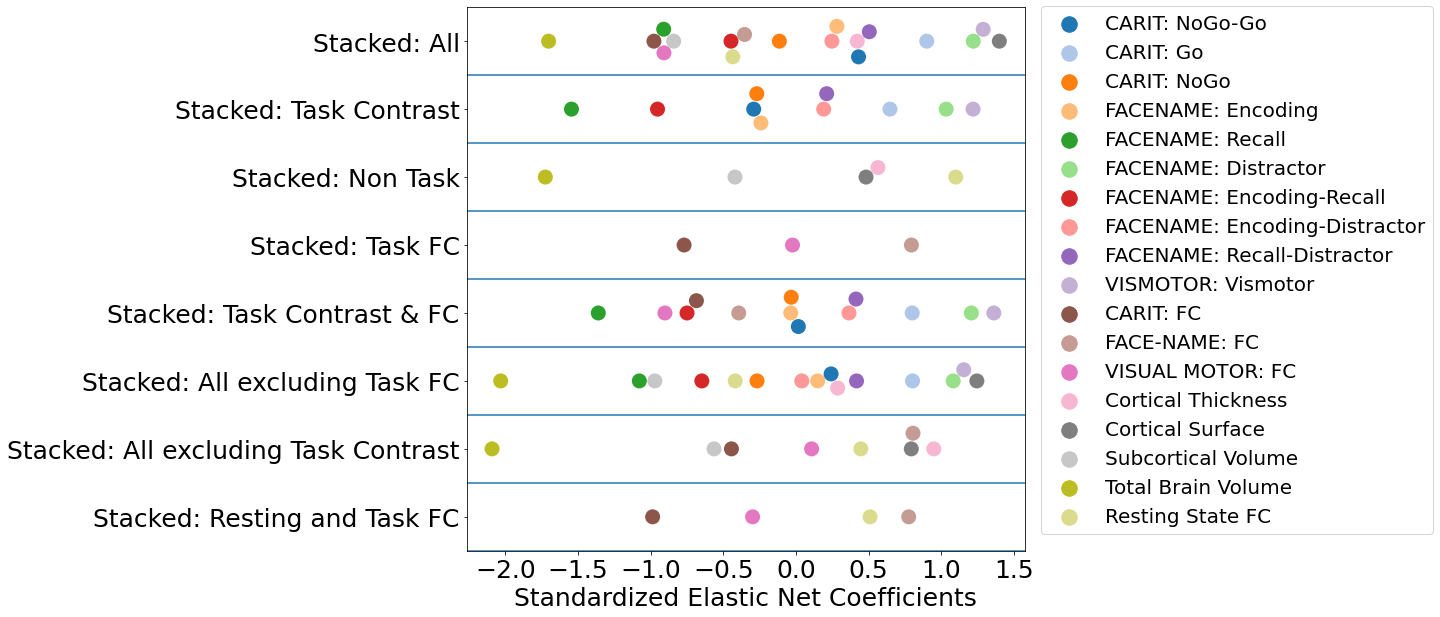

In [19]:
#Plot stacked model coefficients in different way

#standardize each fold feature before plotting

#calculate mean for each stacking set
#+ std feature each fold

dct_mean_stack_coef = {}
for key in dct_stack_coeff.keys():
    dct_mean_stack_coef[key] = pd.DataFrame(StandardScaler().fit_transform(dct_stack_coeff[key].T.values), 
                                            index=dct_stack_coeff[key].T.index, 
                                            columns=dct_stack_coeff[key].T.columns).T.mean()
df_mean_stack_coef = pd.DataFrame(dct_mean_stack_coef)
df_mean_stack_coef = df_mean_stack_coef.reindex(index = dct_mean_stack_coef['set1'].index)
df_mean_stack_coef.index = lblY[:-8] 
df_mean_stack_coef.columns = lblY[-8:]

#reshape
df_plot_ = pd.DataFrame()
for col in df_mean_stack_coef.columns:
    vct = df_mean_stack_coef[col].values
    ind = df_mean_stack_coef[col].index
    sst = np.full(len(ind), col)
    df__ = pd.DataFrame({'val':vct, 'mod':ind, 'set':sst})
    df_plot_ = pd.concat([df_plot_, df__], axis=0, ignore_index=True)
    
#plot
plt.figure(figsize=(10,10))
sns.swarmplot(data=df_plot_, x='val', y='set', hue='mod', orient="h", 
              palette="tab20", size=15)
for i in np.arange(0.5,9,1):
    plt.axhline(y=i)
plt.legend(loc='upper right', bbox_to_anchor=(1.75,1.02), fontsize=20, markerscale=2)
plt.xlabel('Standardized Elastic Net Coefficients', fontsize=25)
plt.ylabel('')
plt.xticks(fontsize=25)
plt.yticks(fontsize=25)
plt.show()

In [20]:
#save table used for upper plotting (with std coeffs)
df_plot_.to_csv(path2+'table_plot_stack_coeff_fluidCog.csv')

In [21]:
#save each modality mean feature coefficients as vector to txt
for key in dct_mean_stack_coef.keys():
    dct_mean_stack_coef[key].to_csv(path2+str(key)+'_Stack_mean_std_elnet_coeffs.txt', header=None)

#### Feature coefficients for single modality models

In [24]:
#extract feature importance from saved models

#for single modalities (except functional connectivities)


dct_elnet_coeff={}

for file in [i.split('/')[-1] for i in sorted(glob.glob(path2+fold+'/*_elnet_model.sav'))]:
    
    if ('_FC_' not in file) and ('rest' not in file):
        
        dct_ = {}
        #extracting feature importance for each fold each modality
        for fold in folders:
            dct_[fold] = (joblib.load(path2+fold+'/'+file)).named_steps['elasticnet'].coef_
        #assign appropriate indexes
        if file.split('_')[0] in ['carit1','carit3','carit4','face1',
                                  'face2','face3','face4','face5','face6','vism']:
            indxs = ind_task
        elif file.split('_')[0] in ['cort', 'surf']:
            indxs = ind_anat
        elif file.split('_')[0] in ['subc']:
            indxs = ind_subc
        elif file.split('_')[0] in ['VolBrain']:    
            indxs = ind_bVol   
            
        df = pd.DataFrame(dct_ , index=indxs).T 
        #save as csv table
        df.to_csv(path2+file.split('_')[0]+'_elnet_coeffs.csv')
        #save to dictionary
        dct_elnet_coeff[file.split('_')[0]] = df

In [25]:
#extract feature importance from saved models

#for single modalities, only functional connectivities


dct_elnet_FC_coeff={}

for file in [i.split('/')[-1] for i in sorted(glob.glob(path2+fold+'/*_elnet_model.sav'))]:
    
    if ('_FC_' in file) or ('rest'  in file):
        
        dct_ = {}
        #assign appropriate indexes
        indxs = ind_FC
        colsx = np.arange(1,76,1)
        #extracting feature importance for each fold each modality
        for fold in folders:
            #extract PCA values (~71000 of ROI pairs into 75 pc)
            pca_model_ind = np.absolute(((joblib.load(path2+fold+'/PCA_models/PCA_model.sav'))[file.replace("_elnet_model.sav", '')]).components_)
            #extract ElasticNet values for 75 pc
            pc_inx = (joblib.load(path2+fold+'/'+file)).named_steps['elasticnet'].coef_
            #multiply PCA values with ElNet values, and summarize across 75 pc for each ROI pair, for one fold
            dct_[fold] = pd.DataFrame( pca_model_ind.T * pc_inx , index = indxs, columns = colsx).T.sum()  
            
        df = pd.DataFrame(dct_).T
        #save as csv table
        df.to_csv(path2+file.replace("_elnet_model.sav", '')+'_elnet_coeffs.csv')
        #save to dictionary
        dct_elnet_FC_coeff[file.replace("_elnet_model.sav", '')] = df

##### Plotting single modality feature importances

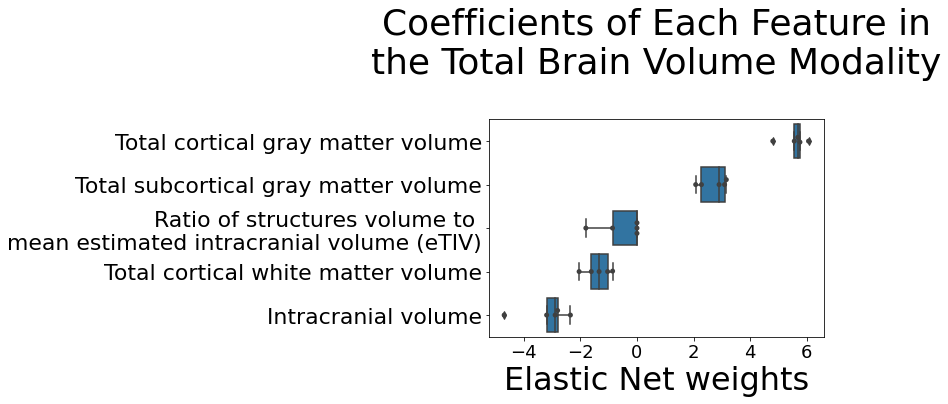

In [26]:
#Total Brain Volume

#non-std coefficients

data = dct_elnet_coeff['VolBrain']
data.columns = ['Intracranial volume',
'Total cortical gray matter volume',
'Total subcortical gray matter volume',
'Total cortical white matter volume',
'Ratio of structures volume to \nmean estimated intracranial volume (eTIV)']

data = data.loc[:, data.mean().sort_values(ascending=False).index]
sns.boxplot(data=data, orient="h", color='tab:blue')
sns.swarmplot(data=data, color=".25", orient="h")

plt.xticks(fontsize=18)
plt.yticks(fontsize=22)
#plt.xlabel('', fontsize=21)
plt.xlabel('Elastic Net weights', fontsize=32)
plt.title('Coefficients of Each Feature in\nthe Total Brain Volume Modality\n',fontsize=36)

plt.show()

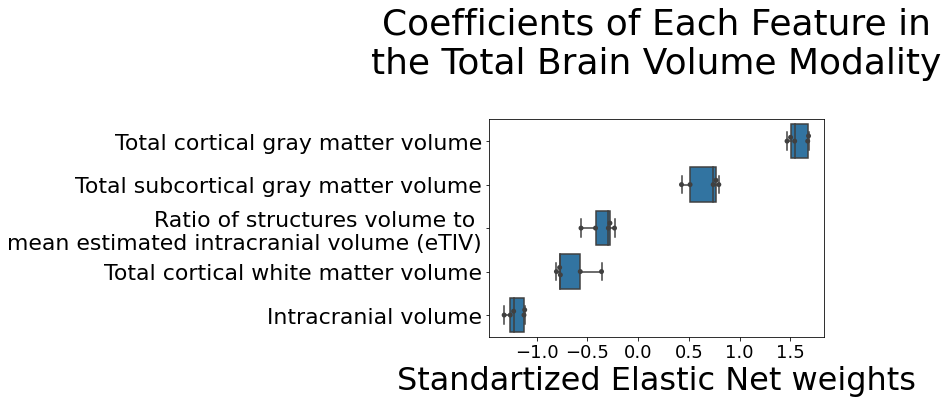

In [27]:
#Total Brain Volume

#std coefficients

data = dct_elnet_coeff['VolBrain']
data.columns = ['Intracranial volume',
'Total cortical gray matter volume',
'Total subcortical gray matter volume',
'Total cortical white matter volume',
'Ratio of structures volume to \nmean estimated intracranial volume (eTIV)']

data = pd.DataFrame(StandardScaler().fit_transform(data.T.values), 
                    index=data.T.index, columns=data.T.columns).T

data = data.loc[:, data.mean().sort_values(ascending=False).index]
sns.boxplot(data=data, orient="h", color='tab:blue')
sns.swarmplot(data=data, color=".25", orient="h")

plt.xticks(fontsize=18)
plt.yticks(fontsize=22)
#plt.xlabel('', fontsize=21)
plt.xlabel('Standartized Elastic Net weights', fontsize=32)
plt.title('Coefficients of Each Feature in\nthe Total Brain Volume Modality\n',fontsize=36)

plt.show()

In [29]:
#save each modality mean feature coefficients as vector to txt (for cifti)
key='VolBrain'
data.mean().to_csv(path2+str(key)+'_mean_std_elnet_coeffs.txt', header=None)

##### Tasks

carit1


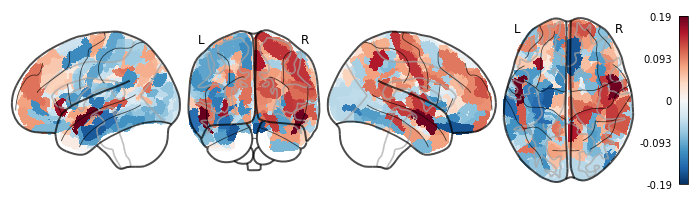

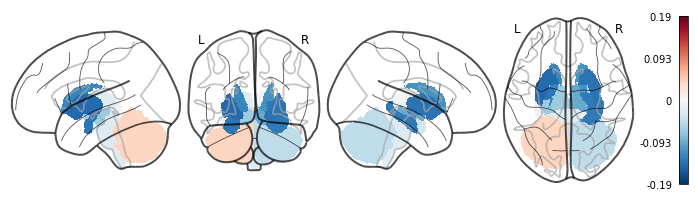

carit3


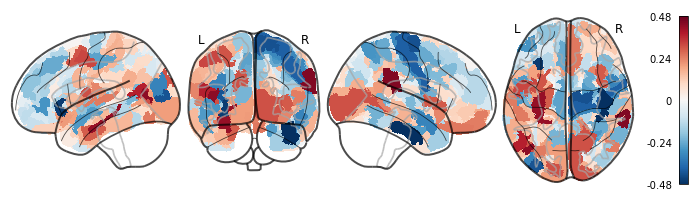

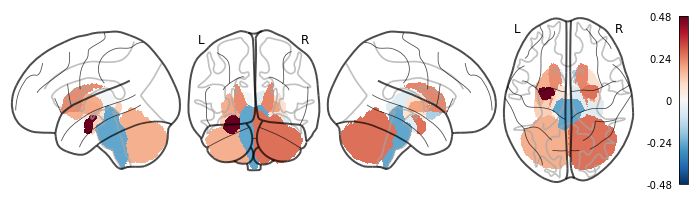

carit4


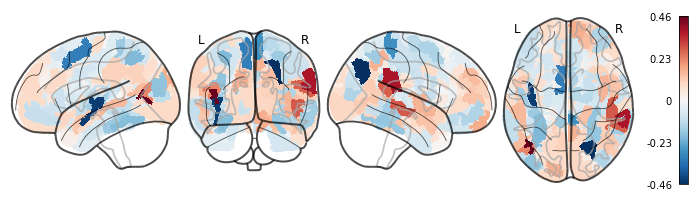

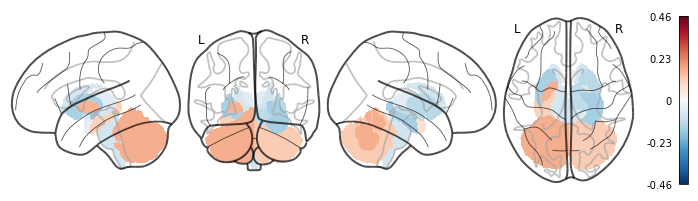

face1


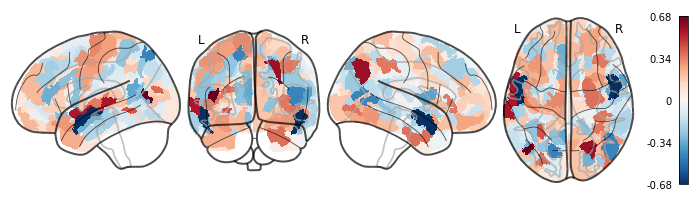

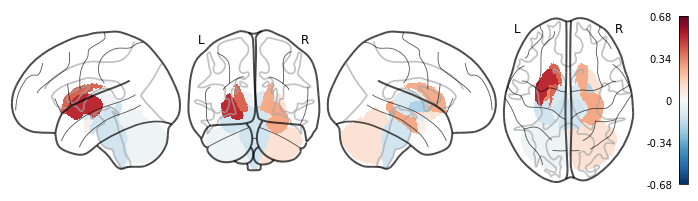

face2


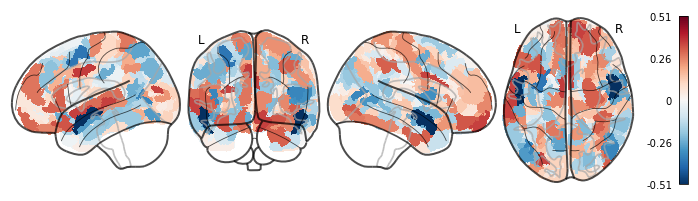

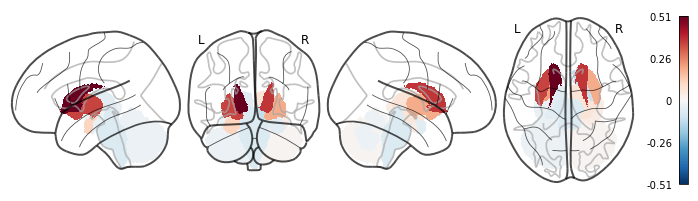

face3


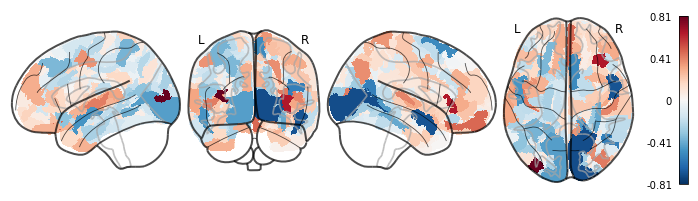

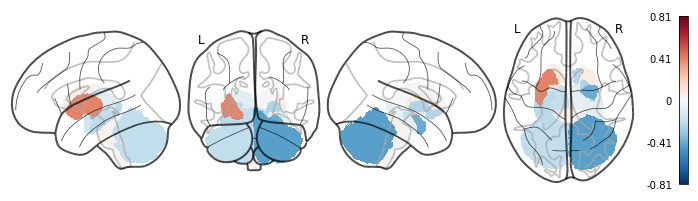

face4


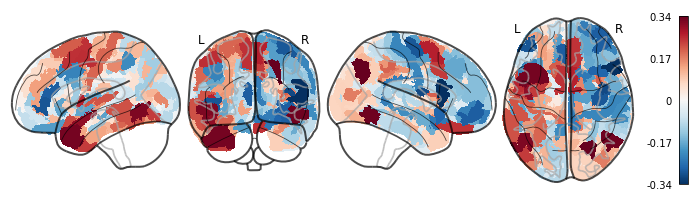

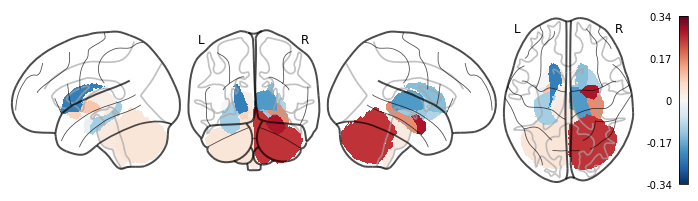

face5


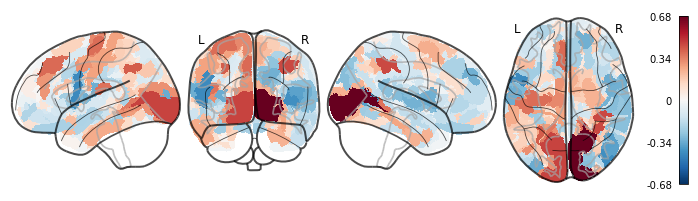

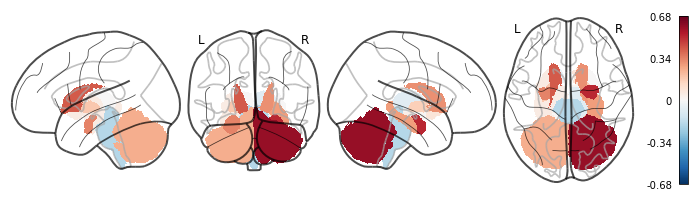

face6


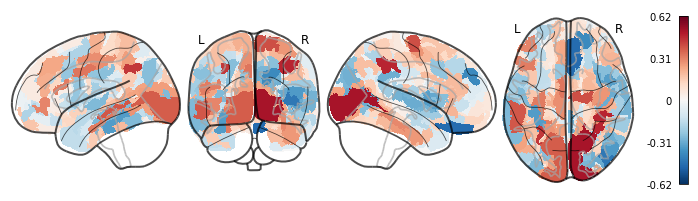

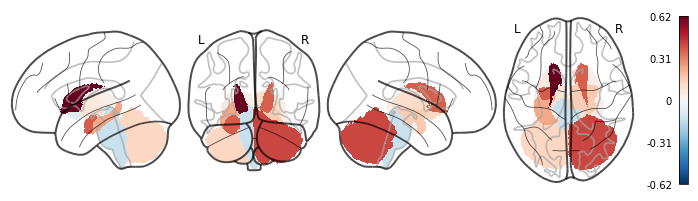

vism


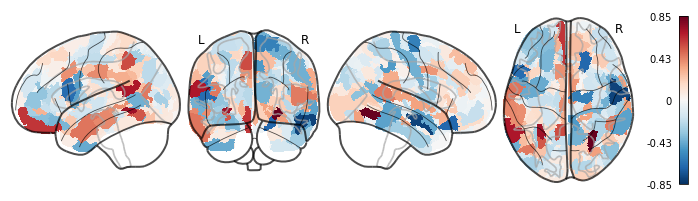

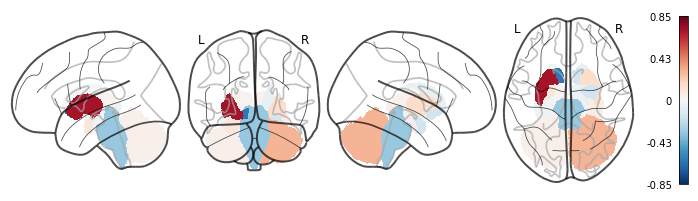

In [30]:
#plot task contrasts on brain

#non-std feature coefficients

#load atlases
wway = '/media/DataD800/Alina/atlases/'
atlas = nli.load_img(wway+'MMP_in_MNI_corr.nii.gz')
atlas2 = nli.load_img(wway+'subc2.fs.nii.gz')

par_dat = atlas.get_fdata()
par_dat2 = atlas2.get_fdata()


for key in ['carit1','carit3','carit4','face1', 'face2','face3','face4','face5','face6','vism']: #contrasts only
    #empty image in the same way as reffered atlas
    site_nii = np.zeros(par_dat.shape)
    site_nii2 = np.zeros(par_dat2.shape)
    #dataframe to plot
    data = dct_elnet_coeff[key]
    
    #cortex according to atlas, 180:360 right hemisphere, 1:180 left. 
    vec = pd.Series(np.concatenate( [(data.mean()[180:360]).values, np.zeros(20), (data.mean()[0:180]).values]))
    #subcortex, the table has same order as atlas
    vec2 = pd.Series((data.mean()[360:]).values, index=pd.read_csv(wway+'atlas_index_num.txt')['nn'].values )

    #fill mat with numbers
    for index, numb in enumerate(vec): 
        site_nii[par_dat == (index+1)] = numb

    for index, numb in zip(vec2.index, vec2.iloc[:]): 
        site_nii2[par_dat2 == (index)] = numb
    
    #create image object
    site_img = nli.new_img_like(atlas, site_nii, atlas.affine, copy_header=True)

    site_img2 = nli.new_img_like(atlas2, site_nii2, atlas2.affine, copy_header=True)
    
    #display
    print(key)
    display1 =plotting.plot_glass_brain(site_img, plot_abs=False, cmap='RdBu_r', 
                                        colorbar=True, display_mode='lyrz', 
                                        vmin=min(data.mean()), vmax=max(data.mean()))
    display2 = plotting.plot_glass_brain(site_img2, plot_abs=False, cmap='RdBu_r', 
                                         colorbar=True, display_mode='lyrz', 
                                         vmin=min(data.mean()), vmax=max(data.mean()))
    plotting.show()

In [31]:
#standardize each fold feature before plotting

carit1


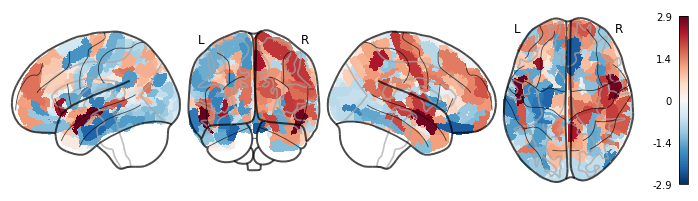

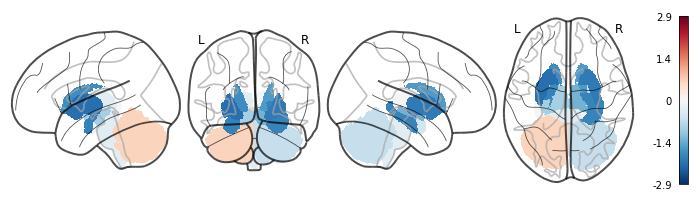

carit3


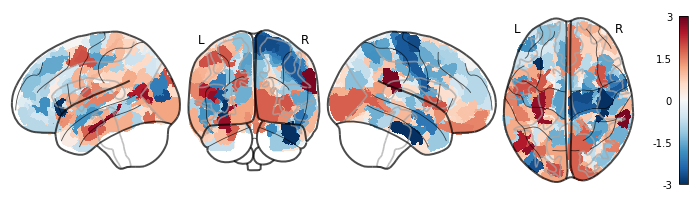

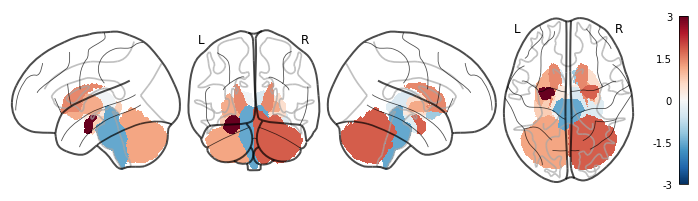

carit4


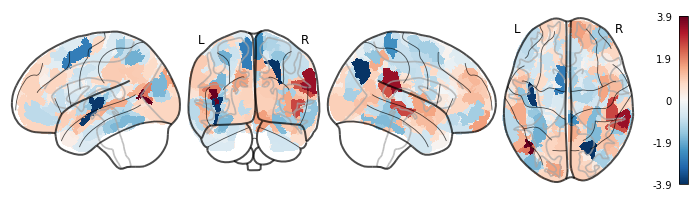

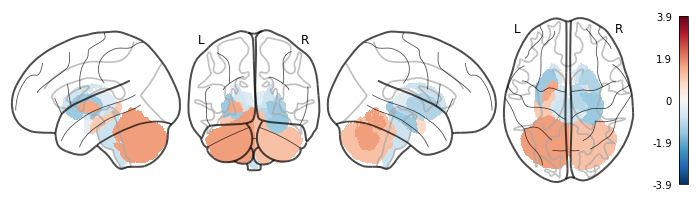

face1


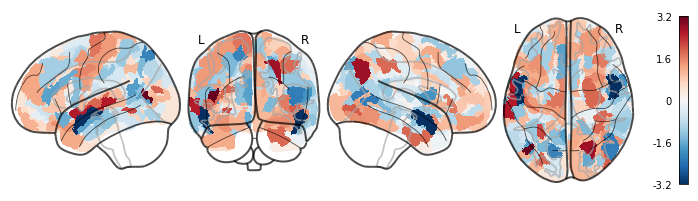

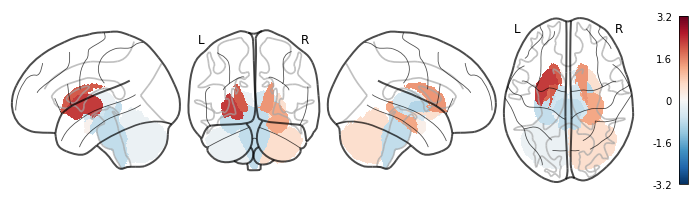

face2


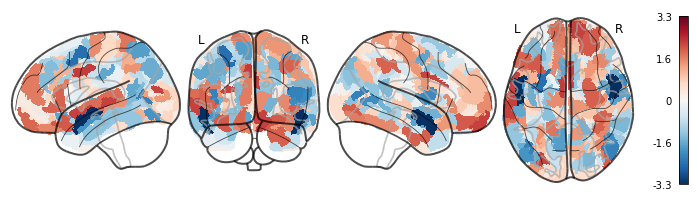

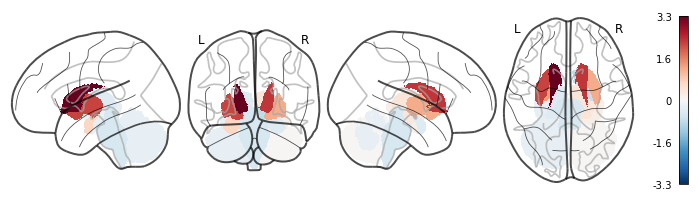

face3


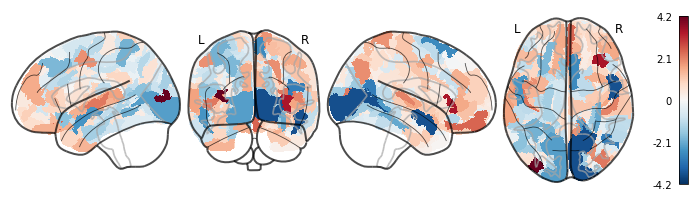

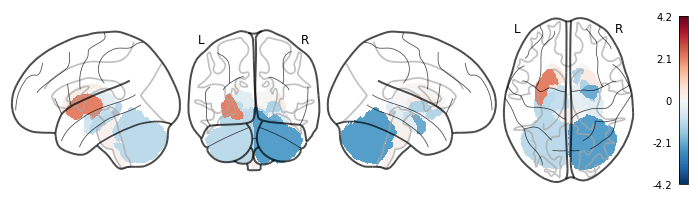

face4


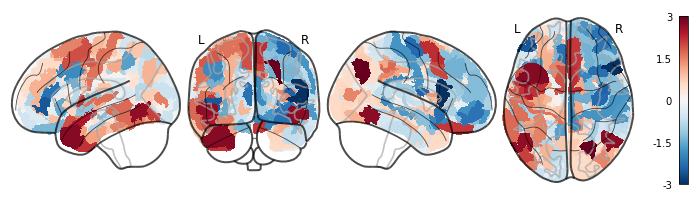

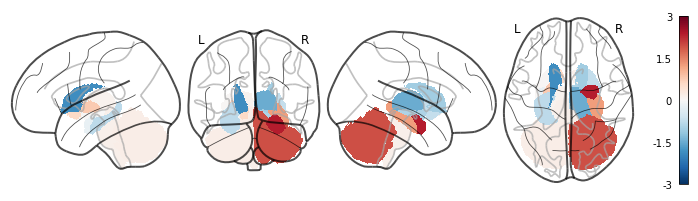

face5


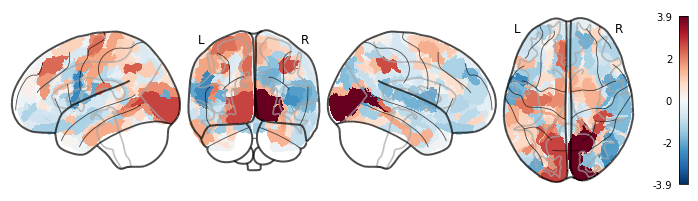

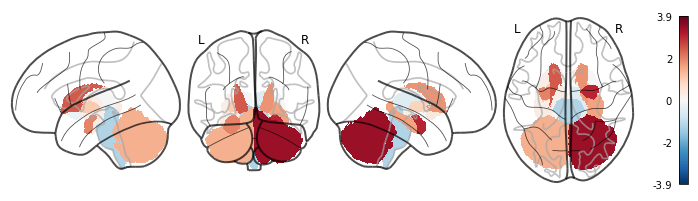

face6


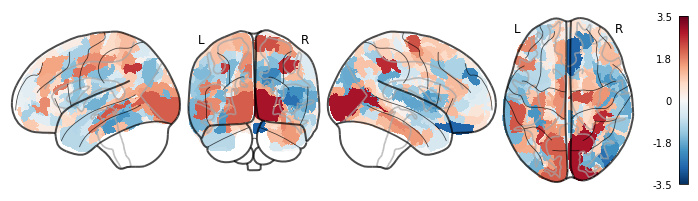

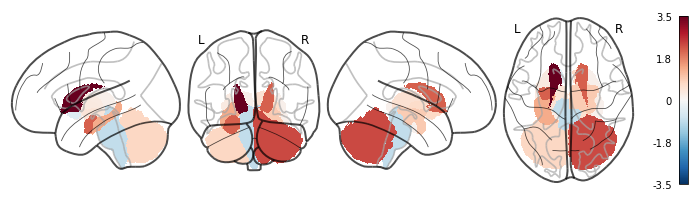

vism


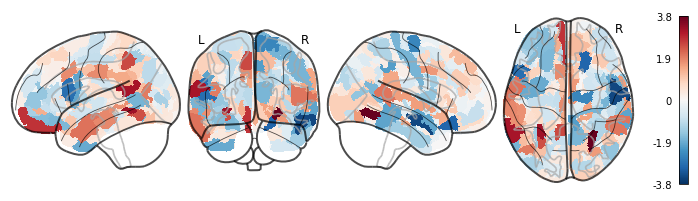

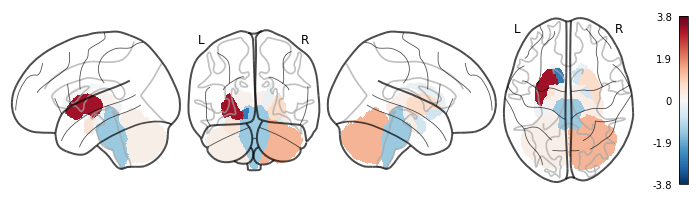

In [32]:
#plot task contrasts on brain

#std feature coefficients

#load atlases
wway = '/media/DataD800/Alina/atlases/'
atlas = nli.load_img(wway+'MMP_in_MNI_corr.nii.gz')
atlas2 = nli.load_img(wway+'subc2.fs.nii.gz')

par_dat = atlas.get_fdata()
par_dat2 = atlas2.get_fdata()


for key in ['carit1','carit3','carit4','face1', 'face2','face3','face4','face5','face6','vism']: #contrasts only
    #empty image in the same way as reffered atlas
    site_nii = np.zeros(par_dat.shape)
    site_nii2 = np.zeros(par_dat2.shape)
    #dataframe to plot
    data = dct_elnet_coeff[key]
    #std dataframe
    data = pd.DataFrame(StandardScaler().fit_transform(data.T.values), 
                        index=data.T.index, columns=data.T.columns).T    
    
    #cortex according to atlas, 180:360 right hemisphere, 1:180 left. 
    vec = pd.Series(np.concatenate( [(data.mean()[180:360]).values, np.zeros(20), (data.mean()[0:180]).values]))
    #subcortex, the table has same order as atlas
    vec2 = pd.Series((data.mean()[360:]).values, index=pd.read_csv(wway+'atlas_index_num.txt')['nn'].values )

    #fill mat with numbers
    for index, numb in enumerate(vec): 
        site_nii[par_dat == (index+1)] = numb

    for index, numb in zip(vec2.index, vec2.iloc[:]): 
        site_nii2[par_dat2 == (index)] = numb
    
    #create image object
    site_img = nli.new_img_like(atlas, site_nii, atlas.affine, copy_header=True)

    site_img2 = nli.new_img_like(atlas2, site_nii2, atlas2.affine, copy_header=True)
    
    #display
    print(key)
    display1 =plotting.plot_glass_brain(site_img, plot_abs=False, cmap='RdBu_r', 
                                        colorbar=True, display_mode='lyrz', 
                                        vmin=min(data.mean()), vmax=max(data.mean()))
    display2 = plotting.plot_glass_brain(site_img2, plot_abs=False, cmap='RdBu_r', 
                                         colorbar=True, display_mode='lyrz', 
                                         vmin=min(data.mean()), vmax=max(data.mean()))
    plotting.show()

carit1


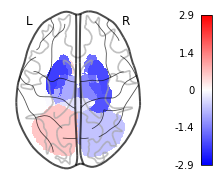

carit3


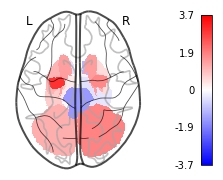

carit4


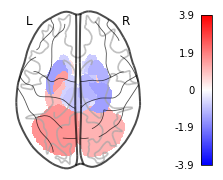

face1


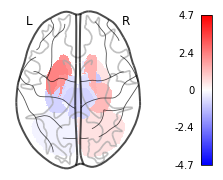

face2


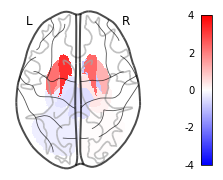

face3


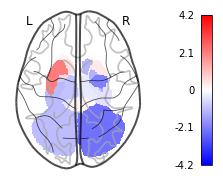

face4


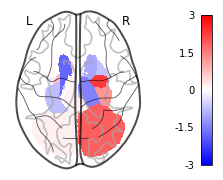

face5


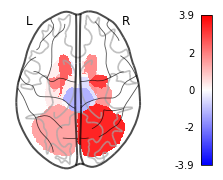

face6


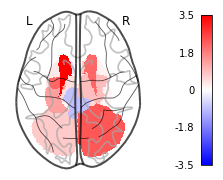

vism


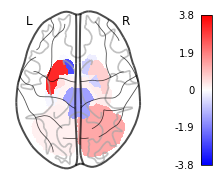

In [33]:
#plot task contrasts on one brain projection, subcortex only

#std feature coefficients


#load atlases
wway = '/media/DataD800/Alina/atlases/'
atlas = nli.load_img(wway+'MMP_in_MNI_corr.nii.gz')
atlas2 = nli.load_img(wway+'subc2.fs.nii.gz')

#par_dat = atlas.get_fdata()
par_dat2 = atlas2.get_fdata()


for key in ['carit1','carit3','carit4','face1', 'face2','face3','face4','face5','face6','vism']: #contrasts only
    #empty image in the same way as reffered atlas
    #site_nii = np.zeros(par_dat.shape)
    site_nii2 = np.zeros(par_dat2.shape)
    #dataframe to plot
    data = dct_elnet_coeff[key]
    #std dataframe
    data = pd.DataFrame(StandardScaler().fit_transform(data.T.values), 
                        index=data.T.index, columns=data.T.columns).T    
    
    #cortex according to atlas, 180:360 right hemisphere, 1:180 left. 
    #vec = pd.Series(np.concatenate( [(data.mean()[180:360]).values, np.zeros(20), (data.mean()[0:180]).values]))
    #subcortex, the table has same order as atlas
    vec2 = pd.Series((data.mean()[360:]).values, index=pd.read_csv(wway+'atlas_index_num.txt')['nn'].values )

    #fill mat with numbers
    #for index, numb in enumerate(vec): 
    #    site_nii[par_dat == (index+1)] = numb

    for index, numb in zip(vec2.index, vec2.iloc[:]): 
        site_nii2[par_dat2 == (index)] = numb
    
    #create image object
    #site_img = nli.new_img_like(atlas, site_nii, atlas.affine, copy_header=True)

    site_img2 = nli.new_img_like(atlas2, site_nii2, atlas2.affine, copy_header=True)
    
    #display
    print(key)
    #display1 =plotting.plot_glass_brain(site_img, plot_abs=False, cmap='RdBu_r', 
    #                                    colorbar=True, display_mode='lyrz', 
    #                                    vmin=min(data.mean()), vmax=max(data.mean()))
    display2 = plotting.plot_glass_brain(site_img2, plot_abs=False, cmap='bwr',        #different colormap
                                         colorbar=True, display_mode='z', 
                                         vmin=min(data.mean()), 
                                         vmax=round(max(max(data.mean()), abs(min(data.mean()))), 2))
    plotting.show()

In [34]:
#save each modality mean feature coefficients as vector to txt for next plotting (cifti)

for key in ['carit1','carit3','carit4','face1', 'face2','face3','face4','face5','face6','vism']:
    #std
    data = dct_elnet_coeff[key]
    data = pd.DataFrame(StandardScaler().fit_transform(data.T.values), 
                        index=data.T.index, columns=data.T.columns).T
    #save txt
    data.mean().to_csv(path2+str(key)+'_mean_std_elnet_coeffs.txt', header=None)
    data.mean()[0:360].to_csv(path2+'mean_'+str(key)+'_cortex_gla_elnet_coeffs_nums.txt', header=None, index=None)
    
    #cifti
    cmd = 'wb_command -cifti-convert -from-text '+path2+'mean_'+str(key)+'_cortex_gla_elnet_coeffs_nums.txt'+' '+wway+'glasser_cifti_empty_template.ptseries.nii' +' '+path2+'mean_'+str(key)+'_cortex_gla_elnet_coeffs.ptseries.nii'
    os.system(cmd)

##### Anatomical (Non-Tasks) Modalities

In [36]:
#assign roi labels, add extra labels for plotting

new_str_ind = list(dct_elnet_coeff['cort'].mean().index)
new_str_ind.insert(41, 'lh_medial_wall')
new_str_ind.insert(116, 'rh_medial_wall')


cort


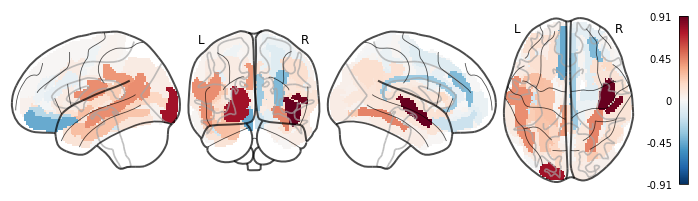

surf


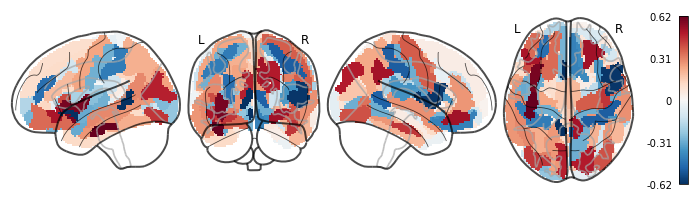

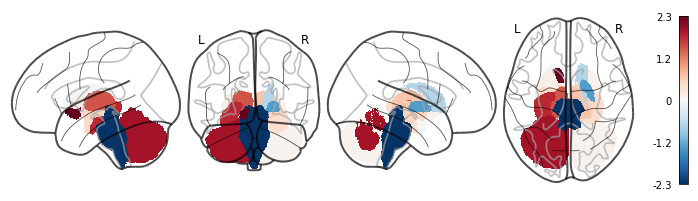

In [37]:
#plot anatomical cortical and subcortical feature importance (from FreeSurfer, Destrieux atlas)

#non-std

#load atlases
atlas = nli.load_img(wway+'destrieux2009_rois_lateralized.nii.gz')
atlas2 = nli.load_img(wway+'subc2.fs.nii.gz')

par_dat = atlas.get_fdata()

#cortex

for key in ['cort', 'surf']:
    #empty image in the same way as reffered atlas
    site_nii = np.zeros(par_dat.shape)
    #dataframe to plot
    data = dct_elnet_coeff[key]#.reindex(columns=new_str_ind).fillna(0)
    #add to columns the med.wall label to match with nii atlas order
    vec = data.mean().reindex(index=new_str_ind).fillna(0)
    vec.index = np.loadtxt(wway+'destrieux2009_new_header_for_table_with_med_wall.txt',dtype=str)
    #fill mat with numbers
    for index, numb in enumerate(vec): 
        site_nii[par_dat == (index+1)] = numb
    #create image object
    site_img = nli.new_img_like(atlas, site_nii, atlas.affine, copy_header=True)
    #display
    print(key)
    display_fs = plotting.plot_glass_brain(site_img, plot_abs=False, cmap='RdBu_r', 
                                           colorbar=True, display_mode='lyrz', 
                                           vmin=min(vec), vmax=max(vec))
    plotting.show()

    
#subcortex

#empty image in the same way as reffered atlas
par_dat2 = atlas2.get_fdata()
site_nii2 = np.zeros(par_dat2.shape)
#reorder subc table into atlas order
v2 = dct_elnet_coeff['subc'].mean()
vec2 =pd.Series(v2.values, index=pd.read_csv(wway+'atlas_index_num.txt')['nn'].values )
#fill mat with numbers
for index, numb in zip(vec2.index, vec2.iloc[:]): 
    site_nii2[par_dat2 == (index)] = numb
#create image object
site_img2 = nli.new_img_like(atlas2, site_nii2, atlas2.affine, copy_header=True)
#display
print('subc')
display_subc = plotting.plot_glass_brain(site_img2, plot_abs=False, cmap='RdBu_r', 
                                         colorbar=True, display_mode='lyrz', 
                                         vmin=min(vec2), vmax=max(vec2))
plotting.show()

In [38]:
#standardized coeffs

cort


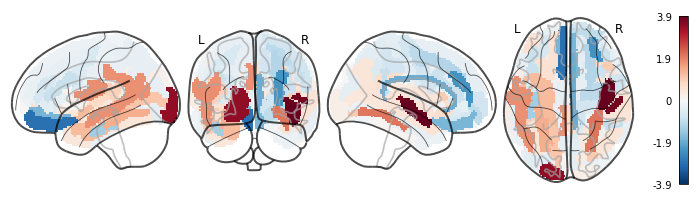

surf


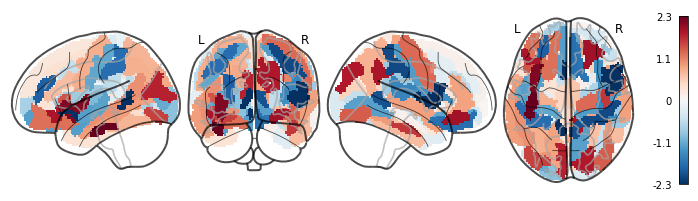

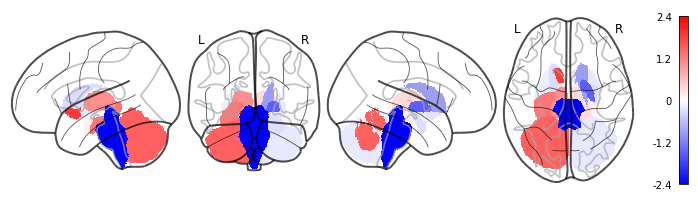

In [39]:
#plot anatomical cortical and subcortical feature importance (from FreeSurfer, Destrieux atlas)

#std

#load atlases
atlas = nli.load_img(wway+'destrieux2009_rois_lateralized.nii.gz')
atlas2 = nli.load_img(wway+'subc2.fs.nii.gz')

par_dat = atlas.get_fdata()

#cortex

for key in ['cort', 'surf']:
    #empty image in the same way as reffered atlas
    site_nii = np.zeros(par_dat.shape)
    #dataframe to plot
    data = dct_elnet_coeff[key]#.reindex(columns=new_str_ind).fillna(0)
    #std
    data = pd.DataFrame(StandardScaler().fit_transform(data.T.values), 
                        index=data.T.index, columns=data.T.columns).T
    #add to columns the med.wall label to match with nii atlas order
    vec = data.mean().reindex(index=new_str_ind).fillna(0)
    vec.index = np.loadtxt(wway+'destrieux2009_new_header_for_table_with_med_wall.txt',dtype=str)
    #fill mat with numbers
    for index, numb in enumerate(vec): 
        site_nii[par_dat == (index+1)] = numb
    #create image object
    site_img = nli.new_img_like(atlas, site_nii, atlas.affine, copy_header=True)
    #display
    print(key)
    display_fs = plotting.plot_glass_brain(site_img, plot_abs=False, cmap='RdBu_r', 
                                           colorbar=True, display_mode='lyrz', 
                                           vmin=min(vec), vmax=max(vec))
    plotting.show()

    
#subcortex

#empty image in the same way as reffered atlas
par_dat2 = atlas2.get_fdata()
site_nii2 = np.zeros(par_dat2.shape)
#reorder subc table into atlas order
dtvc = dct_elnet_coeff['subc']
#std
dtvc = pd.DataFrame(StandardScaler().fit_transform(dtvc.T.values),
                    index=dtvc.T.index, columns=dtvc.T.columns).T
v2 = dtvc.mean()
vec2 =pd.Series(v2.values, index=pd.read_csv(wway+'atlas_index_num.txt')['nn'].values )
#fill mat with numbers
for index, numb in zip(vec2.index, vec2.iloc[:]): 
    site_nii2[par_dat2 == (index)] = numb
#create image object
site_img2 = nli.new_img_like(atlas2, site_nii2, atlas2.affine, copy_header=True)
#display
print('subc')
display_subc = plotting.plot_glass_brain(site_img2, plot_abs=False, cmap='bwr',  #different colormap
                                         colorbar=True, display_mode='lyrz', 
                                         vmin=min(vec2), 
                                         vmax=round(max(max(vec2), abs(min(vec2))), 2))
plotting.show()

In [40]:
#save each modality mean feature coefficients as vector to txt for next plotting (cifti)

for key in  ['cort', 'surf']:
    
    #std
    data = dct_elnet_coeff[key]#.reindex(columns=new_str_ind).fillna(0)
    data = pd.DataFrame(StandardScaler().fit_transform(data.T.values), 
                        index=data.T.index, columns=data.T.columns).T
    
    #save txt
    data.mean().to_csv(path2+str(key)+'_mean_std_elnet_coeffs.txt', header=None)
    data.mean().to_csv(path2+'mean_'+str(key)+'_cortex_destrx_elnet_coeffs_nums.txt', header=None, index=None)
    
    #cifti
    cmd = 'wb_command -cifti-convert -from-text '+path2+'mean_'+str(key)+'_cortex_destrx_elnet_coeffs_nums.txt'+' '+wway+'Destrieux_cifti_empty_template.pscalar.nii' +' '+path2+'mean_'+str(key)+'_cortex_destrx_elnet_coeffs.pscalar.nii'
    os.system(cmd)

##### Resting State and Tasks FC

In [ ]:
#these features in standardized option only

In [42]:
#reorganize from pairs of ROIs back to matrix format

dct_FC_mat = {}
for key in ['rest', 'face_FC', 'vism_FC', 'carit_FC']:
    #dataframe to convert
    data_i  = dct_elnet_FC_coeff[key]

    df_std_FC = pd.DataFrame()
    #standardize
    for indx in data_i.index:
        df_std_FC[indx] = pd.DataFrame(StandardScaler().fit_transform(data_i.loc[indx,:].values.reshape(-1, 1)), 
                                       index=data_i.loc[indx,:].index)[0]
    df_std_FC = df_std_FC.T
    
    #average across folds    
    data = df_std_FC.mean()

    #restore full matrix
    ind379 = np.triu_indices(379, k=1)
    mat379 = np.zeros((379,379),float)
    mat379[ind379]=data.values
    mat379_2 = pd.DataFrame(mat379).replace(0, np.nan)
    mat379_f = pd.DataFrame(np.where(mat379,mat379_2,mat379_2.T))
    mat379_f.index = ind_task
    mat379_f.columns = ind_task
    
    #save mat to dct
    dct_FC_mat[key] = mat379_f
    

rest


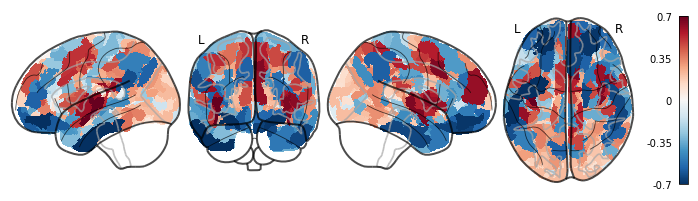

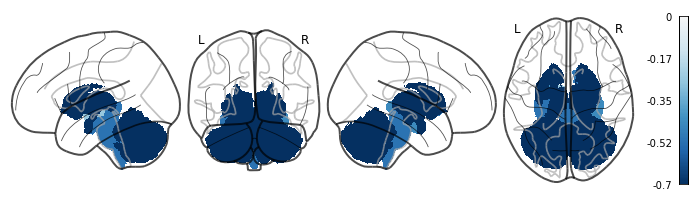

face_FC


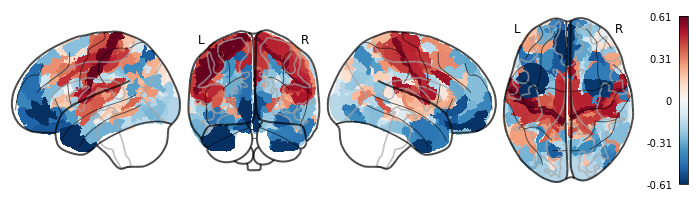

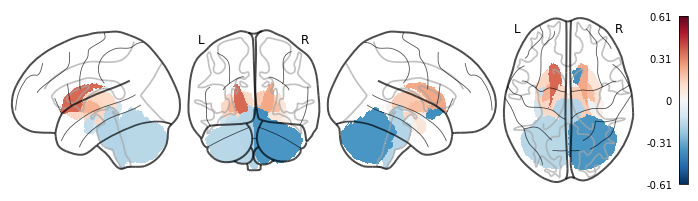

vism_FC


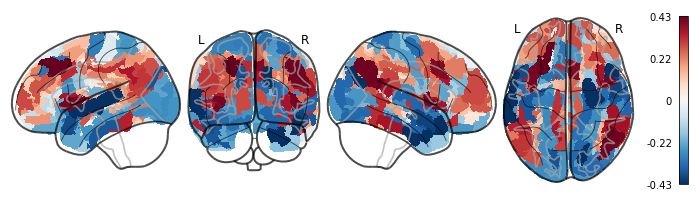

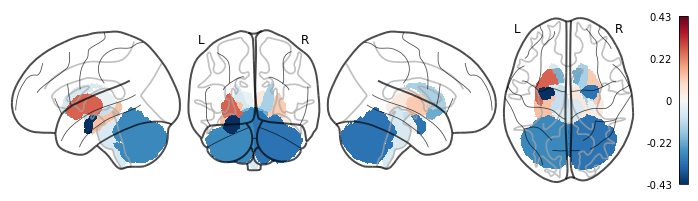

carit_FC


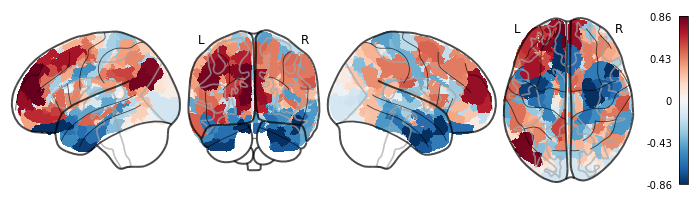

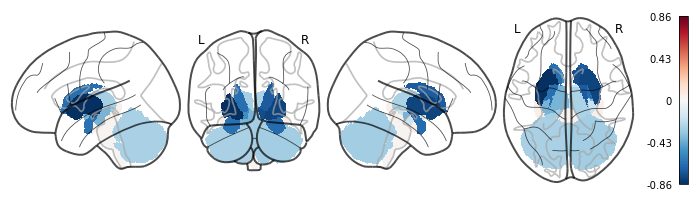

In [43]:
#plot FC values on brain

#already std

#load atlases
wway = '/media/DataD800/Alina/atlases/'
atlas = nli.load_img(wway+'MMP_in_MNI_corr.nii.gz')
atlas2 = nli.load_img(wway+'subc2.fs.nii.gz')

par_dat = atlas.get_fdata()
par_dat2 = atlas2.get_fdata()

for key in ['rest', 'face_FC', 'vism_FC', 'carit_FC']:
    #empty image in the same way as reffered atlas
    site_nii = np.zeros(par_dat.shape)
    site_nii2 = np.zeros(par_dat2.shape)
    #dataframe to plot
    dataFC = dct_FC_mat[key]
    
    #cortex according to atlas, 180:360 right hemisphere, 1:180 left. 
    vec = pd.Series(np.concatenate( [(dataFC.mean()[180:360]).values, np.zeros(20), (dataFC.mean()[0:180]).values]))
    #subcortex, the table has same order as atlas
    vec2 = pd.Series((dataFC.mean()[360:]).values, index=pd.read_csv(wway+'atlas_index_num.txt')['nn'].values )

    #fill mat with numbers
    for index, numb in enumerate(vec): 
        site_nii[par_dat == (index+1)] = numb

    for index, numb in zip(vec2.index, vec2.iloc[:]): 
        site_nii2[par_dat2 == (index)] = numb
    
    #create image object
    site_img = nli.new_img_like(atlas, site_nii, atlas.affine, copy_header=True)

    site_img2 = nli.new_img_like(atlas2, site_nii2, atlas2.affine, copy_header=True)
    
    #display
    print(key)
    display1 =plotting.plot_glass_brain(site_img, plot_abs=False, cmap='RdBu_r', 
                                        colorbar=True, display_mode='lyrz',
                                        vmin=min(dataFC.mean()), vmax=max(dataFC.mean()))
    display2 = plotting.plot_glass_brain(site_img2, plot_abs=False, cmap='RdBu_r', 
                                         colorbar=True, display_mode='lyrz',
                                         vmin=min(dataFC.mean()), vmax=max(dataFC.mean()))
    
    plotting.show()  

rest


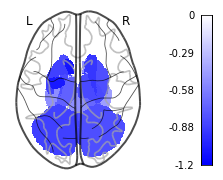

face_FC


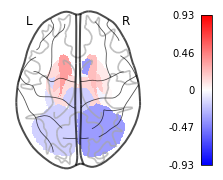

vism_FC


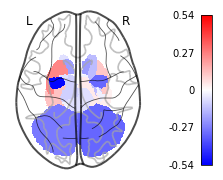

carit_FC


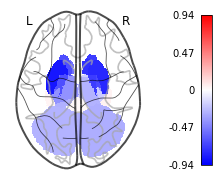

In [44]:
wway = '/media/DataD800/Alina/atlases/'

atlas = nli.load_img(wway+'MMP_in_MNI_corr.nii.gz')
atlas2 = nli.load_img(wway+'subc2.fs.nii.gz')

#par_dat = atlas.get_fdata()
par_dat2 = atlas2.get_fdata()



for key in ['rest', 'face_FC', 'vism_FC', 'carit_FC']:

    #site_nii = np.zeros(par_dat.shape)
    site_nii2 = np.zeros(par_dat2.shape)
       
    dataFC = dct_FC_mat[key]
    
    #cortex according to atlas, 180:360 right hemisphere, 1:180 left. 
    #vec = pd.Series(np.concatenate( [(dataFC.mean()[180:360]).values, np.zeros(20), (dataFC.mean()[0:180]).values]))
    #subcortex, the table has same order as atlas
    vec2 = pd.Series((dataFC.mean()[360:]).values, index=pd.read_csv(wway+'atlas_index_num.txt')['nn'].values )


    #for index, numb in enumerate(vec): 
    #    site_nii[par_dat == (index+1)] = numb

    for index, numb in zip(vec2.index, vec2.iloc[:]): 
        site_nii2[par_dat2 == (index)] = numb

    #site_img = nli.new_img_like(atlas, site_nii, atlas.affine, copy_header=True)

    site_img2 = nli.new_img_like(atlas2, site_nii2, atlas2.affine, copy_header=True)
    
    print(key)
    #display1 =plotting.plot_glass_brain(site_img, plot_abs=False, cmap='RdBu_r', 
    #                                    colorbar=True, display_mode='lyrz',
    #                                    vmin=min(dataFC.mean()), vmax=max(dataFC.mean()))
    display2 = plotting.plot_glass_brain(site_img2, plot_abs=False, cmap='bwr', 
                                         colorbar=True, display_mode='z',
                                         vmin=min(dataFC.mean()), 
                                         vmax=round(max(max(dataFC.mean()), abs(min(dataFC.mean()))), 2))
    
    plotting.show()

In [45]:
#save each modality mean feature coefficients as vector to txt for next plotting (cifti)

for key in ['rest', 'face_FC', 'vism_FC', 'carit_FC']:
    #std
    data = dct_FC_mat[key]

    #save txt
    data.mean().to_csv(path2+str(key)+'_mean_std_elnet_coeffs.txt', header=None)
    data.mean()[0:360].to_csv(path2+'mean_'+str(key)+'_cortex_gla_elnet_coeffs_nums.txt', header=None, index=None)
    
    #cifti
    cmd = 'wb_command -cifti-convert -from-text '+path2+'mean_'+str(key)+'_cortex_gla_elnet_coeffs_nums.txt'+' '+wway+'glasser_cifti_empty_template.ptseries.nii' +' '+path2+'mean_'+str(key)+'_cortex_gla_elnet_coeffs.ptseries.nii'
    os.system(cmd)